# Probabilistic Programming in PyStan

Now that the introductory theory behind MCMC has been discussed, we can move on to explore some examples of its implementation via probabilistic programming in PyStan. We'll do this by addressing a simple linear regression in a Bayesian way, demonstrating the usefulness of priors, and exploring some of the diagnostics that can be used to assess the efficacy of our methods.

The first thing to do, if you haven't already, is to install PyStan, which you can do in Python with the following in the command line:




In [0]:
!pip3 install pystan

Having installed PyStan, we can proceed with generating data and specifying a model. The model we'll be fitting do is that of a straight line, with Gaussian noise:

$y \sim \mathcal{N}(\alpha + \beta x, \sigma)$


So we have a straight line to infer, $\alpha + \beta x$, with data normally distributed about this straight line of standard deviation $\sigma$. We can generate the data with known 'ground truth' values for these parameters, and then test this against the result of our inferences in PyStan to see how well it has done. Note that we have three parameters to infer, the intercept $\alpha$, the gradient, $\beta$, and the standard deviation of noise, $\sigma$ 

To generate this data, we'll use NumPy's random module:



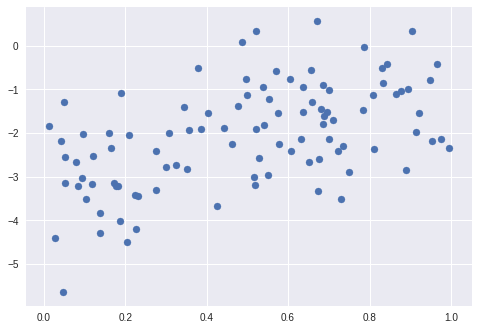

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Specify seed for reproducibility
np.random.seed(101)

# Specify ground truths for parameters
alpha = -3.0
beta = 2.0
sigma = 1.0

# Generate the data and plot
x = np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

plt.scatter(x, y)

At first, it looks like it might be hard to recover the gradient and intercept given the magnitude of noise, but bear in mind that the Bayesian approach will allow for the quantification of uncertainty in our result.

Performing inference in PyStan requires the specification of our model in the probabilistic programming language Stan, which has syntax similar to that of Java and C, and is statically typed. This is done in a model block, with the model being specified separately to the rest of the program. Here, it is assigned to a variable of type string, called `model`.

In [0]:
import pystan

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

Here we can see the three essential blocks in a Stan model, each separated by a keyword and curly braces. In the `data` block, we have the data points, `x` and `y`, which are vectors of length `N`. N is also declared as an `int`, with the lower bound of 0 corresponding to the fact that there can't be a negative quantity of data points. The `parameters` block specifies the parameters for which posterior distributions will be sampled, which are all of type `real`. There is also a lower bound of 0 on `sigma` as the standard deviation of noise can't be negative. Note that this is actually a prior distribution on the parameter `sigma`, restricting the parameter space to only sample from joint distributions where `sigma` is greater than 0.

Finally, we have the model block, where the model itself is specified. This consists of a single-line distribution statement, which is all that is needed to full describe the model, and Stan has in its library all of the commonly encountered statistical distributions. It is in the model block where more complex priors can be specified, such as how we think alpha or beta may be distributed. For the time being, however, let's leave the priors out of it and focus on the sampling process. Addtionally, there are a few other types of block that a Stan model can feature, but we can introduce those at a later stage where they might be useful.

## Sampling

The sampling is done with a single line of Python, which accepts the data and a number of sampling hyperparameters that determine how the sampler generates its posteriors. The data must be formatted in a dictionary, and
before sampling can begin and posteriors can be generated, the model must compile. It is possible to save compiled Stan models and sample from them directly without having to compile, but for this example I will present the entire workflow from end to end.

In [0]:
# Compile the model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


This will generate the following output

Following the successful compiling, we can perform sampling with a single line, using the sampling method of PyStan's `StanModel` class.

In [0]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

Now that our model has compiled, we can print the result of the fit, and plot our posteriors to get a look at the predictions. First, let's print, to see a summary of the results.

In [0]:
print(fit)

Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  -3.14  8.4e-3    0.2  -3.55  -3.28  -3.14   -3.0  -2.76    581    1.0
beta    2.17    0.01   0.36   1.48   1.94   2.16   2.41   2.87    604    1.0
sigma   1.01  2.3e-3   0.07   0.88   0.96   1.01   1.06   1.17   1039    1.0
lp__   -50.7    0.05   1.25 -53.84 -51.25  -50.4  -49.8 -49.29    750    1.0

Samples were drawn using NUTS at Thu Feb  7 12:43:05 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


At first glance, it seems our sampling process has done a pretty good job of identifying our parameters. This fit object summarises the means, standard deviations, and percentiles for the distriubutions of each parameter posterior, along with some diagnostic information about how well the sampling process has converged. A more comprehensive overview of what these diagnostics mean is given in the next section, but for now I wanted to focus on summarising the result of the fit. The level of uncertainty in the parameter estimates is captured in the spread of the posteriors, which can be better appreciated with a graphical plot.

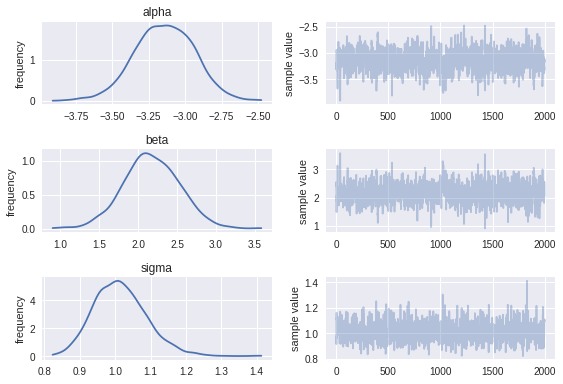

In [0]:
fit.plot().tight_layout()

Here we can see the graphical representation of our posteriors in the left column. Fortunately, they include the ground truth within their most dense regions, which is what we would hope for, and the spread is a measure of how certain we can be in the range of possible parameter values that could have produced our data. These posteriors are simply smoothed histograms of the set of samples generated by the HMC sampling process, on which you can see more detail in the right-hand column.

These are known as trace plots, and show exactly how the sampler moves through the parameter space. Rather than the parameter values being on the horizontal axis as in the case of our posterior plots, these values are on the vertical axis. On the horizontal axis we instead have the number of the sample in the sequence, jumping around as the MCMC method performs its random walk through parameter space, rejecting or accepting new samples in a stochastic manner. It's handy to visualise the posteriors rotated so their parameter axes align, with the trace plots giving you more information about any specific sampling regions that might be contributing to skewed or unusual posteriors.

## Some Prior Recommendations

Before I mentioned that we could add more complex priors in the model block and that this would impact the output of the sampling process. One commonly used prior is that of the normal prior, a normal distribution centred on some reasonable value and with standard deviation corresponding to the level of certainty in this reasonable value. We can implement this in the model block as:

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e2ae9b966727a83418eba0abd8f29e9 NOW.


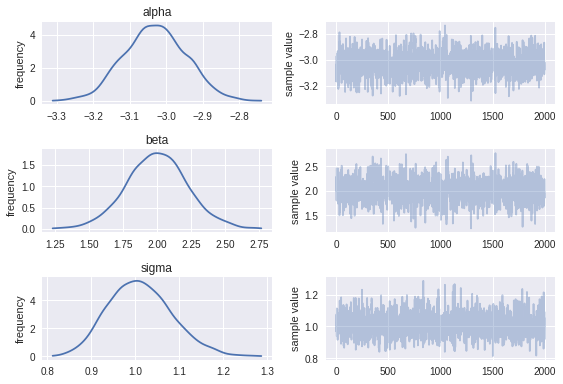

In [0]:
model_prior = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(-3, 0.1);  // Prior on alpha
    y ~ normal(alpha + beta * x, sigma);
}
"""

# Compile new model
sm = pystan.StanModel(model_code=model_prior)

# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

fit.plot().tight_layout()


From this example, we can see that the centre of the distribution for `alpha` has moved closer to its ground truth value of -3.0. Furthermore, the standard deviation for its posterior has shrunk, to reflect the greater degree of certainty in this range of values for `alpha`. 

Notice also a similar effect for `beta` and to a lesser extent, `sigma`, which reflects that in a multidimensional model, if the parameter space for one parameter is restricted by a prior, it makes it easier to have a greater degree of certainty about the other parameters in the model too. If less time is being spent sampling in those low probability ranges of `alpha` as found in the prior, more time can be spent in exploring the parameter space for `beta` and `sigma`.

## Posterior Analysis and Diagnostics

In the line of code for the PyStan sampling method above, there are a number of hyperparameters that will affect this trajectory through parameter space and how the traceplots look. Firstly, `iter` determines how many samples will be generated from each Markov chain, which in this instance was set to 1000. It is desirable to have enough iterations so that we can be confident that the Markov chain has converged to a stationary state and thus will represent the posterior well, but not to have so many iterations that it takes too long to compute. This number will depend on the complexity of the model and can be experimented with to meet the requirements of your own inference problem.

Next, there is `chains`, which is the number of Markov chains to include in the process. This is set to 4 by default, as it is usually adventageous to run multiple entire chains, which will initialise in different regions of parameter space and make sure that the same posterior will be converged to in each case. If multiple chains are converging to different regions of parameter space, you will see a disjointed traceplot, and this will give you multimodal posteriors which might suggest some element of your model is ill-posed.

The next hyperparameter is `warmup`, which determines the number of warmup samples, also sometimes called 'burn-in'. This is the number of samples which get thrown away from the early part of each Markov chain, to ensure that the samples included from the posterior are taken at a stage where each chain has had the opportunity to fully converge, and disregarding any samples that may have been generated before convergence. You can see from our traceplots that 2000 total samples were used in generating our posteriors, coming from 4 chains with 500 samples each. Though each chain was 1000 samples in total, the first 500 were discarded, leaving the latter 500 to contribute to our posteriors.

Then we have `thin`, which determines a regular interval at which to include samples in our final posterior. So, if thin is set to some number $n$, then every $n^{th}$ sample is retained with the others being discarded. This helps to reduce autocorrelation between successive samples, and can be used if your traceplot is looking too linear and not enough like a stochastic random walk.

Finally, we have a seed, which ensures reproducability in the sampling process. This is specified separately to the numpy seed, as Stan's random number generation is separate to that used previously in NumPy's random module

## Diagnostics

Once we've completed our fit, the summary information we printed out above can give us more detailed information about how well our posteriors have converged, and whether we might need to address any problems with our model, data, and priors.

You might notice an additional parameter to those sampled in the print of our fit, listed as `lp__`. This is the log of the joint posterior density 'up to a constant', according to the Stan manual. You don't have to worry about the specific value of this, but a generally useful metric of convergence for your entire model is whether or not `lp__` has properly converged. 

In addtion, we have `Rhat`, also referred to as the Gelman-Rubin convergence statistic. This is a measure of by what scale the variance of the posterior for the parameter of interest would be reduced if sampling was allowed to continue for an infinitely long time. A value of `Rhat` close to 1 is desirable, because it indicates that no further reduction of variance is possible, and that the set Markov chains for that parameter have reached equilibrium.

A further diagnostic that is provided by the output above is `n_eff`, or the effective number of independent samples. Due to correlation between samples, this can be significantly lower than the actual quantity of samples generated. If this number is close to the actual number of samples generated, then this is a positive indicator of independence between successive samples. However, due to the tendency for MCMC methods to produce correlated samples, this is likely to be lower than the sample number and can be somewhat mitigated by making use of the `thin` hyperparameter. 

# Summary

In this chapter, we've described the general features of the Bayesian approach to statistical modelling, as well as the necessity for using computation in generating insight using these methods on data. We've examined Markov chains as a basis for governing the sampling process in a stochastic way, and described how Markov chain Monte Carlo methods like Hamiltonian Monte Carlo generate samples in a computationally efficient way. We've also been introduced the an implementation of these methods in PyStan, which you will see more throughout the book, being applied to different examples with their own challenges. The next chapter deals with many such examples, where we will apply the Bayesian approached outlined in this chapter to a variety of real world problems from which we can generate useful insight.